<a href="https://colab.research.google.com/github/idankri/FinalProjectNLP/blob/main/NLP_Final_Project_Idan_Itai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/uber-research/PPLM
!pip install -r PPLM/requirements.txt

Cloning into 'PPLM'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 276 (delta 70), reused 64 (delta 64), pack-reused 200
Receiving objects: 100% (276/276), 2.43 MiB | 4.53 MiB/s, done.
Resolving deltas: 100% (115/115), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.7 MB 4.3 kB/s 
     |████████████████████████████████| 1.5 MB 51.5 MB/s 
     |████████████████████████████████| 1.3 MB 49.3 MB/s 
     |████████████████████████████████| 62 kB 763 kB/s 
     |████████████████████████████████| 1.2 MB 53.8 MB/s 
     |████████████████████████████████| 880 kB 62.3 MB/s 
     |████████████████████████████████| 2.9 MB 47.3 MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449922 sha256=30d1297498b1a8967d816d577c6208bd5fa12b85d2e17512e318c34bb57051c0
  Stored in direct

In [ ]:
import torch
import torch.nn as nn
#!pip install transformers
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader, RandomSampler
import pandas as pd
import numpy as np
import torch.nn.functional as F
import re
import gc
from tqdm import tqdm
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Small fix for run_pplm
with open('PPLM/run_pplm.py', 'r') as f:
  pplm_filedata = f.read()
  
pplm_filedata = pplm_filedata.replace('tokenizer.vocab_size', 'len(tokenizer)')
with open('PPLM/run_pplm.py', 'w') as f:
  f.write(pplm_filedata)

# Load and Preprocess the data

Define the tokenizer and special tokens

In [ ]:
BOS_TOKEN = "<|startoftext|>"
EOS_TOKEN = "<|endoftext|>"
SEP_TOKEN = "<|sep|>"
PAD_TOKEN = "<|pad|>"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", bos_token=BOS_TOKEN,
                                          eos_token=EOS_TOKEN,
                                          sep_token=SEP_TOKEN,
                                          pad_token=PAD_TOKEN)



Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Download all the scraped data (uploaded into google drive)

In [ ]:
!gdown --id 16cXQbwstoy6TTLZfrjWTcgm6GQdt-xDv # reggae
!gdown --id 1GMa5E0dy-_cVBuXvI5Knpu1UPXfcX8pR # rock
!gdown --id 1ZNKsXu2S3pTY9jnnxmZsMuLh2HPfk-Cn # pop
!gdown --id 1VwUIRUt0VrjjcJ0bTFmmSX0oU57AQ9kj # metal
!gdown --id 14_tsHv8lCpQYSL2hPlTAH3eh0ns4cZsI # hip hop

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16cXQbwstoy6TTLZfrjWTcgm6GQdt-xDv
To: /content/reggae.csv
100% 1.73M/1.73M [00:00<00:00, 54.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GMa5E0dy-_cVBuXvI5Knpu1UPXfcX8pR
To: /content/rock.csv
100% 2.62M/2.62M [00:00<00:00, 120MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://

Preprocess the data

In [ ]:
def clean_lyrics(lyrics):
  lyrics = re.sub('\n{2}', '\n', lyrics)
  lyrics = str(lyrics.strip("\n"))
  lyrics = lyrics.replace("EmbedShare URLCopyEmbedCopy", "").replace("'", "")
  lyrics = re.sub("[\(\[].*?[\)\]]", "", lyrics)
  lyrics = re.sub(r'\d+$', '', lyrics)
  lyrics = str(lyrics).lstrip().rstrip()
  lyrics = str(lyrics).replace('"', "")
  lyrics = str(lyrics).replace("*", "")
  lyrics = str(lyrics).replace("^", "")
  lyrics = re.sub('(\n)+', '\n', lyrics)
  lyrics = re.sub(' +', ' ', lyrics)
  return str(lyrics)

In [ ]:
def emphasize_title(title, lyrics):
  insensitive_title = re.compile(re.escape(title), re.IGNORECASE)
  emph_lyrics = insensitive_title.sub(f'^{title}^', lyrics)
  return str(emph_lyrics)


In [ ]:
def embed_title(title, lyrics):
  insensitive_title = re.compile(re.escape(title), re.IGNORECASE)
  emb_lyrics = insensitive_title.sub('<title>', lyrics)
  return str(emb_lyrics)

In [ ]:
class RawGenreDataset(Dataset):
  def __init__(self, genre):
    self.input_titles = list()
    self.input_text = list()

    data_df = pd.read_csv(f'/content/{genre}.csv')
    for index, row in data_df.iterrows():
      self.input_titles.append(row["song_name"])
      self.input_text.append(clean_lyrics(row["lyrics"]))

  def __len__(self):
    return len(self.input_text)

  def __getitem__(self, idx):
    return self.input_titles[idx], self.input_text[idx]


In [ ]:
# Modes - 'regular', 'emphesize', 'embed'
REGULAR = 'regular'
EMPHESIZE = 'emphesize'
EMBED = 'embed'

class GenreDataset(Dataset):
  def __init__(self, genre, tokenizer, max_length, mode='regular'):
    self.tokenizer = tokenizer
    self.input_ids = list()
    self.attn_masks = list()

    data_df = pd.read_csv(f'/content/{genre}.csv')
    for index, row in data_df.iterrows():
      parsed_lyrics = clean_lyrics(row["lyrics"])
      if mode == REGULAR:
        pass # Do nothing
      elif mode == EMPHESIZE:
        parsed_lyrics = emphasize_title(str(row["song_name"]), parsed_lyrics)
      elif mode == EMBED:
        parsed_lyrics = embed_title(str(row["song_name"]), parsed_lyrics)

      encoding_dict = tokenizer(f'{BOS_TOKEN} [title] {row["song_name"]} [song] {parsed_lyrics} {EOS_TOKEN}',
                                truncation=True,
                                max_length=max_length,
                                padding="max_length")
      self.input_ids.append(torch.tensor(encoding_dict['input_ids']).to(device))
      self.attn_masks.append(torch.tensor(encoding_dict['attention_mask']).to(device))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]


# Training

In [ ]:
def train_model(g_model, data_loader, num_epochs, lr, warmup_steps=100, calc_perplexity=True):
  optimizer = AdamW(g_model.parameters(), lr=lr)#0.00014)
  len_data = len(data_loader)
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = len_data * num_epochs)
  loss_history = []
  ppl_history = []
  for epoch in range(num_epochs):
    total_train_loss = 0
    g_model.train()
    for step, batch in enumerate(data_loader):
      batch_input_ids = batch[0]
      batch_labels = batch[0]
      batch_masks = batch[1]

      if (step + 1) % 50 == 0:
        print(f"epoch {epoch + 1}/{num_epochs}: step {step + 1} out of {len_data}.\
        Loss: {total_train_loss / 50}")
        loss_history.append(total_train_loss / 50)
        total_train_loss = 0
        if calc_perplexity:
          g_model.eval()
          stride = 256
          max_length = 768
          nlls = []
          for i in range(0, batch_input_ids.size(1), stride):
            begin_loc = max(i + stride - max_length, 0)
            end_loc = min(i + stride, batch_input_ids.size(1))
            trg_len = end_loc - i  # may be different from stride on last loop
            input_ids = batch_input_ids[:, begin_loc:end_loc].to(device)
            target_ids = input_ids.clone()
            target_ids[:, :-trg_len] = -100

            with torch.no_grad():
                outputs = g_model(input_ids, labels=target_ids)
                neg_log_likelihood = outputs[0] * trg_len

            nlls.append(neg_log_likelihood)

          ppl = torch.exp(torch.stack(nlls).sum() / end_loc).item()
          ppl_history.append(ppl)
          print(f"Perplexity: {ppl}")
          g_model.train()


      batch_input_ids = batch[0]
      batch_labels = batch[0]
      batch_masks = batch[1]
      g_model.zero_grad()

      outputs = g_model(batch_input_ids,
                      labels=batch_labels, 
                      attention_mask=batch_masks)
      loss = outputs[0]
      batch_loss = loss.item()
      total_train_loss += batch_loss
      loss.backward()
      optimizer.step()
      scheduler.step()
  return loss_history, ppl_history

In [ ]:
def generate_model(tokenizer):
  config = GPT2Config.from_pretrained("gpt2")
  config.vocab_size = gpt2_tokenizer.vocab_size
  model = GPT2LMHeadModel(config).to(device)
  model.resize_token_embeddings(len(gpt2_tokenizer))
  return model

In [ ]:
num_epochs = 2
loss_data = {'metal':[], 'hiphop':[], 'pop':[], 'reggae':[], 'rock':[]}
ppl_data = {'metal':[], 'hiphop':[], 'pop':[], 'reggae':[], 'rock':[]}
for genre in ['hiphop', 'pop', 'reggae', 'rock', 'metal']:
  dataset = GenreDataset(genre=genre, tokenizer=gpt2_tokenizer, max_length=768)
  dataloader = DataLoader(
      dataset,
      sampler=RandomSampler(dataset),
      batch_size=4
  )
  model = generate_model(gpt2_tokenizer)
  loss_history, ppl_history = train_model(model, dataloader, num_epochs, 5e-4)
  torch.save(model.state_dict(), f"/content/{genre}_model.pickle")
  model.save_pretrained(f'{genre}_model')
  gpt2_tokenizer.save_pretrained(f'{genre}_model')
  # # Models occupy big chung of memory so to save space we manually deallocate them
  loss_data[genre] = loss_history
  ppl_data[genre] = ppl_history
  dataset = None
  dataloader = None
  model = None
  gc.collect()
  torch.cuda.empty_cache()

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

epoch 1/2: step 50 out of 575.        Loss: 7.31591908454895
Perplexity: 251.57278442382812
epoch 1/2: step 100 out of 575.        Loss: 5.268362641334534
Perplexity: 217.59117126464844
epoch 1/2: step 150 out of 575.        Loss: 5.180515475273133
Perplexity: 363.295654296875
epoch 1/2: step 200 out of 575.        Loss: 4.82599217414856
Perplexity: 309.35382080078125
epoch 1/2: step 250 out of 575.        Loss: 4.757107291221619
Perplexity: 230.7768096923828
epoch 1/2: step 300 out of 575.        Loss: 4.651052122116089
Perplexity: 184.6844940185547
epoch 1/2: step 350 out of 575.        Loss: 4.595779519081116
Perplexity: 85.48307800292969
epoch 1/2: step 400 out of 575.        Loss: 4.6186773443222044
Perplexity: 94.93257141113281
epoch 1/2: step 450 out of 575.        Loss: 4.548953490257263
Perplexity: 62.74225997924805
epoch 1/2: step 500 out of 575.        Loss: 4.4156660032272335
Perplexity: 31.598373413085938
epoch 1/2: step 550 out of 575.        Loss: 4.283005061149598
Perpl

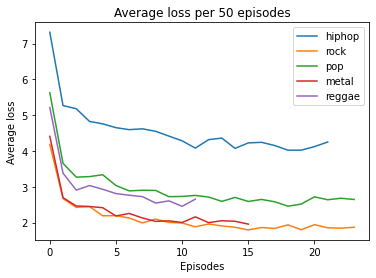

In [ ]:
hiphop_episodes = [i for i in range(len(loss_data['hiphop']))]
plt.plot(hiphop_episodes, loss_data['hiphop'], label='hiphop')
rock_episodes = [i for i in range(len(loss_data['rock']))]
plt.plot(rock_episodes, loss_data['rock'], label='rock')
pop_episodes = [i for i in range(len(loss_data['pop']))]
plt.plot(pop_episodes, loss_data['pop'], label='pop')
metal_episodes = [i for i in range(len(loss_data['metal']))]
plt.plot(metal_episodes, loss_data['metal'], label='metal')
reggae_episodes = [i for i in range(len(loss_data['reggae']))]
plt.plot(reggae_episodes, loss_data['reggae'], label='reggae')

plt.xlabel('Episodes')
plt.ylabel('Average loss')
plt.title('Average loss per 50 episodes')
plt.legend()

plt.show()

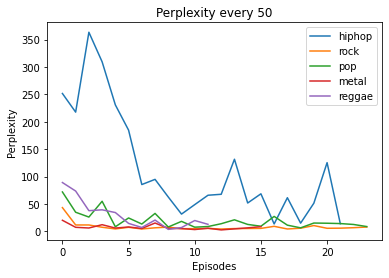

In [ ]:
plt.plot(hiphop_episodes, ppl_data['hiphop'], label='hiphop')
plt.plot(rock_episodes, ppl_data['rock'], label='rock')
plt.plot(pop_episodes, ppl_data['pop'], label='pop')
plt.plot(metal_episodes, ppl_data['metal'], label='metal')
plt.plot(reggae_episodes, ppl_data['reggae'], label='reggae')

plt.xlabel('Episodes')
plt.ylabel('Perplexity')
plt.title('Perplexity every 50')
plt.legend()

plt.show()

Optional download of fine tuned models

In [ ]:
!cat ~/.cache/gdown/cookies.json

[]

In [ ]:
!gdown --id 1k9q5b0TaD0P_I9w5ygMJQ4enaI2KcYsK # hiphop trained model
!gdown --id 1cMSWDlY0xYW4WJM0MYHu4WOWewOwsulq # pop trained model
!gdown --id 1IsFd5-0mhXuuEL2rzTA6MD_HcZ2TwP3v # reggae trained model
!gdown --id 1J2DV2Yyic7o6f9HUIRNtXCLElStv6K2V # rock trained model
!gdown --id 1SQkCryrkQaIu5xwXG_hZ0ECR-H9Oknzw # metal trained model


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1k9q5b0TaD0P_I9w5ygMJQ4enaI2KcYsK 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser

In [ ]:
def generate(
    model,
    tokenizer,
    prompt,
    entry_length=768, #maximum number of tokens to generate
    top_p=0.8,
    temperature=1.,
):

    model.eval()
    #generated_list = []
    
    filter_value = -float("Inf")

    with torch.no_grad():
        entry_finished = False

        generated = torch.tensor(tokenizer.encode(prompt), device=model.device).unsqueeze(0)
        nstart = generated.shape[-1]
        
        for nth in range(entry_length):

            # outputs = model(generated, labels=generated)
            loss, logits, __ = model(generated, labels=generated)#.to_tuple()

            logits = logits[:, -1, :] / temperature

            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[:, indices_to_remove] = filter_value

            next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            generated = torch.cat((generated, next_token), dim=1)

            ## Flag whether or not the next token is the end-to-string special token
            entry_finished = (next_token.item() == tokenizer.eos_token_id)
            
            ## stop early if end-of-sequence token is reached:
            if entry_finished: break
        
        ngenerated = (generated.shape[-1] - nstart)
        assert ngenerated == (nth+1), "sanity check failed; check loop"

        output_list = list(generated.cpu().squeeze().numpy())
        #output_text = f"{tokenizer.decode(output_list)}{'' if entry_finished else '<|endoftext|>'}"

        ### only return the new (generated) text: 
        generated_list = output_list#output_list[-ngenerated:]
        generated_text = f"{tokenizer.decode(generated_list)}{'' if entry_finished else tokenizer.eos_token}"
        
    return generated_text


# Some other approaches

Try train on emphesized title / embedded title

In [ ]:
for data_mode in [EMPHESIZE, EMBED]:
  for genre in ['pop']:
    dataset = GenreDataset(genre=genre, tokenizer=gpt2_tokenizer, max_length=768, mode=data_mode)
    dataloader = DataLoader(
        dataset,
        sampler=RandomSampler(dataset),
        batch_size=4
    )
    model = generate_model(gpt2_tokenizer)
    _, _ = train_model(model, dataloader, 1, 5e-4)
    torch.save(model.state_dict(), f"/content/{genre}_model_{data_mode}.pickle")
    #model.save_pretrained(f'{genre}_model_{data_mode}')
    #gpt2_tokenizer.save_pretrained(f'{genre}_model_{data_mode}')
    # # Models occupy big chung of memory so to save space we manually deallocate them
    dataset = None
    dataloader = None
    model = None
    gc.collect()
    torch.cuda.empty_cache()

epoch 1/1: step 50 out of 602.        Loss: 5.6371645879745484
Perplexity: 42.42115783691406
epoch 1/1: step 100 out of 602.        Loss: 3.7216075897216796
Perplexity: 68.23955535888672
epoch 1/1: step 150 out of 602.        Loss: 3.4612300753593446
Perplexity: 54.964454650878906
epoch 1/1: step 200 out of 602.        Loss: 3.2724720883369445
Perplexity: 37.90092468261719
epoch 1/1: step 250 out of 602.        Loss: 3.2393064093589783
Perplexity: 46.61799621582031
epoch 1/1: step 300 out of 602.        Loss: 2.9787239360809328
Perplexity: 12.803979873657227
epoch 1/1: step 350 out of 602.        Loss: 3.042630181312561
Perplexity: 72.635986328125
epoch 1/1: step 400 out of 602.        Loss: 2.94074978351593
Perplexity: 30.505783081054688
epoch 1/1: step 450 out of 602.        Loss: 2.964028398990631
Perplexity: 13.102715492248535
epoch 1/1: step 500 out of 602.        Loss: 2.8952740621566773
Perplexity: 12.321443557739258
epoch 1/1: step 550 out of 602.        Loss: 2.853523347377777

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(gpt2_tokenizer))
model.load_state_dict(torch.load('/content/pop_model_emphesize.pickle'))

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
print(generate(model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Stairway to Heaven [song] "))

<|startoftext|>  [title] Stairway to Heaven [song] 
But she where you, yeah, hey
So I can hurt we got
I want to make me and you aint know I will take a real in you, why in the Eyes
That but its

I just in this good to tell atime things from the little feet you and my mistake, I know it here
Why just the name all my found the hundred up to be him
Come it like you cant run and ^Then shere ^Just for me
We let me in you
I think to feel
M doing in my heart of
Oh, take me
Oh,
So its the face, its sleep to his heart
Were a ^Baby dont ever let the way
And I just got my body
Baby, put the nasty.
How give
We got in the name

Oooh yeah, come just have I got a thing all the brother in his sit a very home
Id come.
Im own
If you
For you a chance, my ^I <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|p

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(gpt2_tokenizer))
model.load_state_dict(torch.load('/content/pop_model_embed.pickle'))

<All keys matched successfully>

In [ ]:
generated = (generate(model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Stairway to Heaven [song] "))
print(generated.replace('<title>', 'Stairway to Heaven'))

<|startoftext|>  [title] Stairway to Heaven [song] 
Oo year are these soul
Uh in my moment in your lonely here I got love to have us thing down as the bathroom time
Well thats to living of a mistakes and you love to youre a choice
Stairway to Heaven
And cant find my good to cant let me, one down to free?
Well, no do me
My eyes
But I can be better Stairway to Heaven
And you see I could know you keep her
Im not Stairway to Heaven, no word to you were not be as you
Sont goin me to my town
Im not all my all theres is not find the name 
Ch Eyes up that you feel?
And I <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|

# PPLM

Bag of words that consists only of song name

In [ ]:
!echo "wrecking" > song_name.txt
#!echo "to" >> song_name.txt
!echo "ball" >> song_name.txt

In [ ]:
!CUDA_VISIBLE_DEVICES=$N python PPLM/run_pplm.py -B song_name.txt --pretrained_model=/content/metal_model --cond_text="[title] Wrecking Ball [song]" --num_samples=1 --length=150 --stepsize=0.07 --num_iterations=3 --window_length=5 --gamma=1.5 --gm_scale=0.95 --kl_scale=0.01 --colorama --verbosity='regular' --sample

= Prefix of sentence =
<|startoftext|> [title] Wrecking Ball [song]

Using PPLM-BoW
/usr/local/lib/python3.7/dist-packages/transformers/modeling_gpt2.py:759: FutureWarning: The `past` argument is deprecated and will be removed in a future version, use `past_key_values` instead.
  FutureWarning,
<|startoftext|> [title] Wrecking Ball [song] You
<|startoftext|> [title] Wrecking Ball [song] You know
<|startoftext|> [title] Wrecking Ball [song] You know I
<|startoftext|> [title] Wrecking Ball [song] You know I cant
<|startoftext|> [title] Wrecking Ball [song] You know I cant see
<|startoftext|> [title] Wrecking Ball [song] You know I cant see you
<|startoftext|> [title] Wrecking Ball [song] You know I cant see you

<|startoftext|> [title] Wrecking Ball [song] You know I cant see you
I
<|startoftext|> [title] Wrecking Ball [song] You know I cant see you
I feel
<|startoftext|> [title] Wrecking Ball [song] You know I cant see you
I feel the
<|startoftext|> [title] Wrecking Ball [song] You know

Bag of words that consists of a whole song lyrics without stop words

In [ ]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
rock_dataset = RawGenreDataset(genre="rock")

In [ ]:
song_text = [d for d in rock_dataset if d[0].startswith("Highway To Hell")][0][1].lower()
text_tokens = word_tokenize(song_text)
personal_pronouns= ['i', 'you', 'she', 'he', 'they']
tokens_without_sw = [word for word in text_tokens if (not word in stopwords.words()) and word.isalpha() and word not in personal_pronouns]
with open('song_text.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(tokens_without_sw))

In [ ]:
!CUDA_VISIBLE_DEVICES=1 python PPLM/run_pplm.py -B song_text.txt --pretrained_model=/content/hiphop_model --cond_text="[title] Highway To Hell [song]" --num_samples=2 --length=150 --stepsize=0.07 --num_iterations=3 --window_length=5 --gamma=1.5 --gm_scale=0.95 --kl_scale=0.01 --colorama --verbosity='regular' --sample

= Prefix of sentence =
<|startoftext|> [title] Highway To Hell [song]

Using PPLM-BoW
/usr/local/lib/python3.7/dist-packages/transformers/modeling_gpt2.py:759: FutureWarning: The `past` argument is deprecated and will be removed in a future version, use `past_key_values` instead.
  FutureWarning,
<|startoftext|> [title] Highway To Hell [song] Yeah
<|startoftext|> [title] Highway To Hell [song] Yeah,
<|startoftext|> [title] Highway To Hell [song] Yeah, I
<|startoftext|> [title] Highway To Hell [song] Yeah, I do
<|startoftext|> [title] Highway To Hell [song] Yeah, I do,
<|startoftext|> [title] Highway To Hell [song] Yeah, I do, you
<|startoftext|> [title] Highway To Hell [song] Yeah, I do, you a
<|startoftext|> [title] Highway To Hell [song] Yeah, I do, you a little
<|startoftext|> [title] Highway To Hell [song] Yeah, I do, you a little new
<|startoftext|> [title] Highway To Hell [song] Yeah, I do, you a little new
<|startoftext|> [title] Highway To Hell [song] Yeah, I do, you a little n

PPLM e2e activation

In [ ]:
def generate_pplm_params(song_name, file_name):
  song_prefix = f"[title] {song_name} [song]"
  tokenized_title = song_name
  title_tokens = word_tokenize(song_name)
  title_tokens = [word.lower() for word in title_tokens]
  personal_pronouns= ['i', 'you', 'she', 'he', 'they']
  tokens_without_sw = [word for word in title_tokens if (not word in stopwords.words()) and word.isalpha() and word not in personal_pronouns]
  with open(file_name, 'w') as f:
    f.write('\n'.join(tokens_without_sw))
  
  return song_prefix

In [ ]:
model_to_run = '/content/hiphop_model'
song_pref = generate_pplm_params('Gangstas paradise', 'song_name.txt')

In [ ]:
!CUDA_VISIBLE_DEVICES=1 python PPLM/run_pplm.py -B song_name.txt --pretrained_model=$model_to_run --cond_text="$song_pref" --num_samples=1 --length=150 --stepsize=0.047 --num_iterations=3 --window_length=5 --gamma=1.5 --gm_scale=0.95 --kl_scale=0.01 --colorama --verbosity='regular' --sample > pplm_output.txt

/usr/local/lib/python3.7/dist-packages/transformers/modeling_gpt2.py:759: FutureWarning: The `past` argument is deprecated and will be removed in a future version, use `past_key_values` instead.
  FutureWarning,


In [ ]:
with open('pplm_output.txt', 'r') as f:
  pplm_output = f.read()

pplm_results = pplm_output.split("Unperturbed generated text =\n")[1].split("\n= Perturbed generated text 1 =\n")
pplm_unperturbed = pplm_results[0]
pplm_perturbed = pplm_results[1]
print(pplm_perturbed)

<|startoftext|>[title] Gangstas paradise [song] Im so long,
Yeah, I dont know, I can I wasnt do,
I got a way that I dont know I a bitch, I aint been down
I dont want a bitch, Im so much
You wanna make aint never need
Im in your mind
I know why Imma go to me
But she aint been so much one
But I got aint got it
But I know, I can do youre going up in aint a minute, I wanna get your own time, I can do that I dont wanna take me, its the one, I can take it,
I know, I dont know you a girl, but its nothin? I know? Yeah,




# Analyzing the models

In [ ]:
sentence_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


In [ ]:
def get_embed(s, encoder):
  return np.array(encoder([s])[0])

In [ ]:
def cosine_similarity(text1, text2, encoder):
  embed1 = get_embed(text1, encoder)
  embed2 = get_embed(text2, encoder)
  return embed1.dot(embed2) # The google sentence encoder outputs normalized vectors

In [ ]:
hiphop_model = GPT2LMHeadModel.from_pretrained('gpt2')
hiphop_model.resize_token_embeddings(len(gpt2_tokenizer))
hiphop_model.load_state_dict(torch.load('/content/hiphop_model.pickle'))

pop_model = GPT2LMHeadModel.from_pretrained('gpt2')
pop_model.resize_token_embeddings(len(gpt2_tokenizer))
pop_model.load_state_dict(torch.load('/content/pop_model.pickle'))

reggae_model = GPT2LMHeadModel.from_pretrained('gpt2')
reggae_model.resize_token_embeddings(len(gpt2_tokenizer))
reggae_model.load_state_dict(torch.load('/content/reggae_model.pickle'))

metal_model = GPT2LMHeadModel.from_pretrained('gpt2')
metal_model.resize_token_embeddings(len(gpt2_tokenizer))
metal_model.load_state_dict(torch.load('/content/metal_model.pickle'))

rock_model = GPT2LMHeadModel.from_pretrained('gpt2')
rock_model.resize_token_embeddings(len(gpt2_tokenizer))
rock_model.load_state_dict(torch.load('/content/rock_model.pickle'))

<All keys matched successfully>

In [ ]:
target = generate(hiphop_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Gangsta's paradise [song] ")
hiphop_different_song = generate(hiphop_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Stairway to Heaven [song] ")

pop_same_song = generate(pop_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Gangsta's paradise [song] ")
pop_different_song = generate(pop_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Stairway to Heaven [song] ")

rock_same_song = generate(rock_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Gangsta's paradise [song] ")
rock_different_song = generate(rock_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Stairway to Heaven [song] ")

raggae_same_song = generate(reggae_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Gangsta's paradise [song] ")
raggae_different_song = generate(reggae_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Stairway to Heaven [song] ")

metal_same_song = generate(metal_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Gangsta's paradise [song] ")
metal_different_song = generate(metal_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Stairway to Heaven [song] ")

In [ ]:
print(f'hiphop vs hiphop: {cosine_similarity(target, hiphop_different_song, sentence_encoder)}')

print(f'hiphop vs pop (same title): {cosine_similarity(target, pop_same_song, sentence_encoder)}')
print(f'hiphop vs pop (different title): {cosine_similarity(target, pop_different_song, sentence_encoder)}')

print(f'hiphop vs raggae (same title): {cosine_similarity(target, raggae_same_song, sentence_encoder)}')
print(f'hiphop vs raggae (different title): {cosine_similarity(target, raggae_different_song, sentence_encoder)}')

print(f'hiphop vs rock (same title): {cosine_similarity(target, rock_same_song, sentence_encoder)}')
print(f'hiphop vs rock (different title): {cosine_similarity(target, rock_different_song, sentence_encoder)}')

print(f'hiphop vs metal (same title): {cosine_similarity(target, metal_same_song, sentence_encoder)}')
print(f'hiphop vs metal (different title): {cosine_similarity(target, metal_different_song, sentence_encoder)}')

hiphop vs hiphop: 0.7459737658500671
hiphop vs pop (same title): 0.699384331703186
hiphop vs pop (different title): 0.6408092975616455
hiphop vs raggae (same title): 0.16130708158016205
hiphop vs raggae (different title): 0.5888108611106873
hiphop vs rock (same title): 0.6830134391784668
hiphop vs rock (different title): 0.6003087759017944
hiphop vs metal (same title): 0.10725696384906769
hiphop vs metal (different title): 0.6551201343536377


In [ ]:
generated_songs = [target, hiphop_different_song, 
                   pop_same_song, pop_different_song,
                   rock_same_song, rock_different_song,
                   metal_same_song, metal_different_song,
                   raggae_same_song, raggae_different_song]
generated_same_songs = [pop_same_song,
                   rock_same_song,
                   metal_same_song,
                   raggae_same_song]
generated_different_songs = [pop_different_song,
                    rock_different_song,
                  metal_different_song,
                 raggae_different_song]

cosine_same_results = [cosine_similarity(target, song, sentence_encoder) for song in generated_same_songs]
cosine_different_results = [cosine_similarity(target, song, sentence_encoder) for song in generated_different_songs]

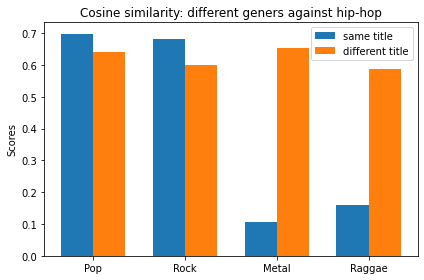

In [ ]:
labels = ['Pop', 'Rock', 'Metal', 'Raggae']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cosine_same_results, width, label='same title')
rects2 = ax.bar(x + width/2, cosine_different_results, width, label='different title')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Cosine similarity: different geners against hip-hop')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
cosine_matirx = [cosine_similarity(song1, song2, sentence_encoder) for song1 in generated_songs for song2 in generated_songs]

np.array(cosine_matirx).reshape(len(generated_songs),len(generated_songs))

generated_songs_titles = ['Hiphop title 1', 'Hiphop title 2', 
                   'Pop title 1', 'Pop title 2',
                   'Rock title 1', 'Rock title 2',
                   'Metal title 1', 'Metal title 2',
                   'Raggae title 1', 'Raggae title 2']

cosine_matirx_panda = pd.DataFrame(np.array(cosine_matirx).reshape(len(generated_songs),len(generated_songs)), columns =generated_songs_titles, index=generated_songs_titles)

In [ ]:
cosine_matirx_panda

,Hiphop title 1,Hiphop title 2,Pop title 1,Pop title 2,Rock title 1,Rock title 2,Metal title 1,Metal title 2,Raggae title 1,Raggae title 2
Hiphop title 1,1.000000,0.745974,0.699384,0.640809,0.683013,0.600309,0.107257,0.655120,0.161307,0.588811
Hiphop title 2,0.745974,1.000000,0.806135,0.713885,0.749985,0.619948,0.135599,0.717733,0.210612,0.629936
Pop title 1,0.699384,0.806135,1.000000,0.787081,0.799821,0.622754,0.172510,0.730305,0.207991,0.631965
Pop title 2,0.640809,0.713885,0.787081,1.000000,0.767958,0.705387,0.219005,0.742594,0.227046,0.697002
Rock title 1,0.683013,0.749985,0.799821,0.767958,1.000000,0.704372,0.144944,0.785288,0.223384,0.751896
Rock title 2,0.600309,0.619948,0.622754,0.705388,0.704372,1.000000,0.101543,0.710797,0.137391,0.683073
Metal title 1,0.107257,0.135599,0.172510,0.219005,0.144944,0.101543,1.000000,0.127177,0.678054,0.084849
Metal title 2,0.655120,0.717733,0.730305,0.742594,0.785288,0.710796,0.127177,1.000000,0.159940,0.681677
Raggae title 1,0.161307,0.210612,0.207991,0.227046,0.223384,0.137391,0.678054,0.159940,1.000000,0.167591
Raggae title 2,0.588811,0.629936,0.631965,0.697002,0.751896,0.683073,0.084849,0.681677,0.167591,1.000000


# Testing cosine similarity of generated songs vs real songs

In [ ]:
model_to_run = '/content/pop_model'
song_pref = generate_pplm_params('i kissed a girl', 'i_kissed_a_girl.txt')

!CUDA_VISIBLE_DEVICES=1 python PPLM/run_pplm.py -B i_kissed_a_girl.txt --pretrained_model=$model_to_run --cond_text="$song_pref" --num_samples=1 --length=150 --stepsize=0.047 --num_iterations=3 --window_length=5 --gamma=1.5 --gm_scale=0.95 --kl_scale=0.01 --colorama --verbosity='regular' --sample \
            > pplm_i_kissed_a_girl.txt

with open('pplm_i_kissed_a_girl.txt', 'r') as f:
  pplm_output = f.read()

pplm_results = pplm_output.split("Unperturbed generated text =\n")[1].split("\n= Perturbed generated text 1 =\n")
i_kissed_a_girl_unperturbed = pplm_results[0]
i_kissed_a_girl_perturbed = pplm_results[1]


/usr/local/lib/python3.7/dist-packages/transformers/modeling_gpt2.py:759: FutureWarning: The `past` argument is deprecated and will be removed in a future version, use `past_key_values` instead.
  FutureWarning,


In [ ]:
# gen_i_kissed_a_girl = generate(pop_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] I kissed a girl [song] ")
gen_i_kissed_a_girl = pop_same_song

In [ ]:
model_to_run = '/content/reggae_model'
song_pref = generate_pplm_params('Under The Mango Tree', 'Under_The_Mango_Tree.txt')

!CUDA_VISIBLE_DEVICES=1 python PPLM/run_pplm.py -B Under_The_Mango_Tree.txt --pretrained_model=$model_to_run --cond_text="$song_pref" --num_samples=1 --length=150 --stepsize=0.047 --num_iterations=3 --window_length=5 --gamma=1.5 --gm_scale=0.95 --kl_scale=0.01 --colorama --verbosity='regular' --sample \
            > pplm_Under_The_Mango_Tree.txt

with open('pplm_Under_The_Mango_Tree.txt', 'r') as f:
  pplm_output = f.read()

pplm_results = pplm_output.split("Unperturbed generated text =\n")[1].split("\n= Perturbed generated text 1 =\n")
Under_The_Mango_Tree_unperturbed = pplm_results[0]
Under_The_Mango_Tree_perturbed = pplm_results[1]


/usr/local/lib/python3.7/dist-packages/transformers/modeling_gpt2.py:759: FutureWarning: The `past` argument is deprecated and will be removed in a future version, use `past_key_values` instead.
  FutureWarning,


In [ ]:
gen_Under_The_Mango_Tree = generate(pop_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Under The Mango Tree [song] ")

In [ ]:
model_to_run = '/content/metal_model'
song_pref = generate_pplm_params('Empty walls', 'Empty_walls.txt')

!CUDA_VISIBLE_DEVICES=1 python PPLM/run_pplm.py -B Empty_walls.txt --pretrained_model=$model_to_run --cond_text="$song_pref" --num_samples=1 --length=150 --stepsize=0.047 --num_iterations=3 --window_length=5 --gamma=1.5 --gm_scale=0.95 --kl_scale=0.01 --colorama --verbosity='regular' --sample \
            > pplm_Empty_walls.txt

with open('pplm_Empty_walls.txt', 'r') as f:
  pplm_output = f.read()

pplm_results = pplm_output.split("Unperturbed generated text =\n")[1].split("\n= Perturbed generated text 1 =\n")
Empty_walls_unperturbed = pplm_results[0]
Empty_walls_perturbed = pplm_results[1]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_gpt2.py:759: FutureWarning: The `past` argument is deprecated and will be removed in a future version, use `past_key_values` instead.
  FutureWarning,


In [ ]:
gen_empty_walls = generate(metal_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] Empty walls [song] ")

In [ ]:
model_to_run = '/content/rock_model'
song_pref = generate_pplm_params('We will rock you', 'We_will_rock_you.txt')

!CUDA_VISIBLE_DEVICES=1 python PPLM/run_pplm.py -B We_will_rock_you.txt --pretrained_model=$model_to_run --cond_text="$song_pref" --num_samples=1 --length=150 --stepsize=0.047 --num_iterations=3 --window_length=5 --gamma=1.5 --gm_scale=0.95 --kl_scale=0.01 --colorama --verbosity='regular' --sample \
            > pplm_We_will_rock_you.txt

with open('pplm_We_will_rock_you.txt', 'r') as f:
  pplm_output = f.read()

pplm_results = pplm_output.split("Unperturbed generated text =\n")[1].split("\n= Perturbed generated text 1 =\n")
We_will_rock_you_unperturbed = pplm_results[0]
We_will_rock_you_perturbed = pplm_results[1]


/usr/local/lib/python3.7/dist-packages/transformers/modeling_gpt2.py:759: FutureWarning: The `past` argument is deprecated and will be removed in a future version, use `past_key_values` instead.
  FutureWarning,


In [ ]:
gen_we_will_rock_you = generate(rock_model, gpt2_tokenizer, f"{BOS_TOKEN} [title] We will rock you [song] ")

In [ ]:
gangstas_paradise = "As I walk through the valley of the shadow of death\nI take a look at my life, and realize there's nothin' left\n'Cause I've been blastin' and laughin' so long\nThat even my momma thinks that my mind is gone\nBut I ain't never crossed a man that didn't deserve it\nMe be treated like a punk, you know that's unheard of\nYou better watch how you talkin' and where you walkin'\nOr you and your homies might be lined in chalk\nI really hate to trip, but I gotta loc\nAs they croak, I see myself in the pistol smoke\nFool, I'm the kinda G the little homies wanna be like\nOn my knees in the night, sayin' prayers in the streetlight\nBeen spendin' most their lives livin' in the gangsta's paradise\nBeen spendin' most their lives livin' in the gangsta's paradise\nKeep spendin' most our lives livin' in the gangsta's paradise\nKeep spendin' most our lives livin' in the gangsta's paradise\nLook at the situation they got me facin'\nI can't live a normal life, I was raised by the street\nSo I gotta be down with the hood team\nToo much television watchin' got me chasin' dreams\nI'm a educated fool with money on my mind\nGot my ten in my hand and a gleam in my eye\nI'm a loc'd out gangsta, set trippin' banger\nAnd my homies is down so don't arouse my anger\nFool, death ain't nothin' but a heart beat away\nI'm livin' life do or die, what can I say?\nI'm 23 now, but will I live to see 24?\nThe way things is goin', I don't know\nTell me why are we so blind to see\nThat the ones we hurt are you and me?\nBeen spendin' most their lives livin' in the gangsta's paradise\nBeen spendin' most their lives livin' in the gangsta's paradise\nKeep spendin' most our lives livin' in the gangsta's paradise\nKeep spendin' most our lives livin' in the gangsta's paradise\nPower and the money, money and the power\nMinute after minute, hour after hour\nEverybody's runnin', but half of them ain't lookin'\nIt's goin' on in the kitchen, but I don't know what's cookin'\nThey say I gotta learn, but nobody's here to teach me\nIf they can't understand it, how can they reach me?\nI guess they can't, I guess they won't\nI guess they frontin', that's why I know my life is out of luck, fool!\nBeen spendin' most their lives livin' in the gangsta's paradise\nBeen spendin' most their lives livin' in the gangsta's paradise\nKeep spendin' most our lives livin' in the gangsta's paradise\nKeep spendin' most our lives livin' in the gangsta's paradise\nTell me why are we so blind to see\nThat the ones we hurt are you and me?\nTell me why are we so blind to see\nThat the ones we hurt are you and me?'"

i_kissed_a_girl = "'This was never the way I planned\nNot my intention\nI got so brave, drink in hand\nLost my discretion\nIt's not what I'm used to\nJust wanna try you on\nI'm curious for you\nCaught my attention\nI kissed a girl and I liked it\nThe taste of her cherry chap stick\nI kissed a girl just to try it\nI hope my boyfriend don't mind it\nIt felt so wrong\nIt felt so right\nDon't mean I'm in love tonight\nI kissed a girl and I liked it\nI liked it\nNo, I don't even know your name\nIt doesn't matter\nYou're my experimental game\nJust human nature\nIt's not what, good girls do\nNot how they should behave\nMy head gets so confused\nHard to obey\nI kissed a girl and I liked it\nThe taste of her cherry chap stick\nI kissed a girl just to try it\nI hope my boyfriend don't mind it\nIt felt so wrong\nIt felt so right\nDon't mean I'm in love tonight\nI kissed a girl and I liked it\nI liked it\nUs girls we are so magical\nSoft skin, red lips, so kissable\nHard to resist so touchable\nToo good to deny it\nAin't no big deal, it's innocent\nI kissed a girl and I liked it\nThe taste of her cherry chap stick\nI kissed a girl just to try it\nI hope my boyfriend don't mind it\nIt felt so wrong\nIt felt so right\nDon't mean I'm in love tonight\nI kissed a girl and I liked it\nI liked it'"

we_will_rock_you = "Buddy, you're a boy, make a big noise\nPlaying in the street, gonna be a big man someday\nYou got mud on your face, you big disgrace\nKicking your can all over the place, singin'\nWe will, we will rock you\nWe will, we will rock you\nBuddy, you're a young man, hard man\nShouting in the street, gonna take on the world someday\nYou got blood on your face, you big disgrace\nWaving your banner all over the place\nWe will, we will rock you, sing it!\nWe will, we will rock you, yeah\nBuddy, you're an old man, poor man\nPleading with your eyes, gonna get you some peace someday\nYou got mud on your face, big disgrace\nSomebody better put you back into your place, do it!\nWe will, we will rock you, yeah, yeah, come on\nWe will, we will rock you, alright, louder!\nWe will, we will rock you, one more time\nWe will, we will rock you\nYeah\n"

Under_The_Mango_Tree = "'Underneath the Mango Tree\nMe honey and me can watch for the moon\nUnderneath the Mango Tree\nMe honey and me make boolooloop soon\nUnderneath the moonlit sky\nMe honey and I can sit hand in hand\nUnderneath the moonlit sky\nMe honey and I can make fairyland\nMango, banana and tangerine\nSugar and ackee and cocoa bean\nWhen we get marry we make them grow\nAnd nine little chil' in a row\nUnderneath the Mango Tree\nMe honey and me can watch for the moon\nUnderneath the Mango Tree\nMe honey and me we plan marry soon\nMango, banana and tangerine\nSugar and ackee and cocoa bean\nWhen we get marry we make them grow\nAnd nine little chil' in a row\nUnderneath the Mango Tree\nMe honey and me can watch for the moon\nUnderneath the Mango Tree\nMe honey and me we plan marry soon\nUnderneath the Mango Tree\nUnderneath the Mango Tree\nUnderneath the Mango Tree\n'"

empty_walls = "Your empty walls\nYour empty walls\nPretentious attention\nDismissive apprehension\nDon't waste your time\nOn coffins today\nWhen we decline\nFrom the confines of our mind\nDon't waste your time\nOn coffins today\nDon't you see their bodies burning?\nDesolate and full of yearning\nDying of anticipation\nChoking from intoxication\nDon't you see their bodies burning?\nDesolate and full of yearning\nDying of anticipation\nChoking from intoxication\nI want you to be left behind those empty walls\nTaunt you to see from behind those empty walls\nThose empty walls\nWhen we decline\nFrom the confines of our mind\nDon't waste your time\nOn coffins today\nDon't you see their bodies burning?\nDesolate and full of yearning\nDying of anticipation\nChoking from intoxication\nDon't you see their bodies burning?\nDesolate and full of yearning\nDying of anticipation\nChoking from intoxication\nI want you to be left behind those empty walls\nTaunt you to see from behind those empty walls\nWant you to be left behind those empty walls\nI taunt you to see from behind those empty walls\nFrom behind those empty walls\nFrom behind those empty walls, the walls\nFrom behind those empty walls\nI loved you yesterday (from behind those empty walls)\nBefore you killed my family (from behind those empty walls, the walls)\nDon't you see their bodies burning?\nDesolate and full of yearning\nDying of anticipation\nChoking from intoxication\nDon't you see their bodies burning\nDesolate and full of yearning\nDying of anticipation\nChoking from intoxication\nI want you to be left behind those empty walls\nTaunt you to see from behind those empty walls\nI want you to be left behind those empty walls\nI taunt you to see from behind those empty walls\nFrom behind those empty walls\nFrom behind those fucking walls\nFrom behind those goddamn walls\nThose walls, those walls"

In [ ]:
print('Pop')
print(f'non-pplm: {cosine_similarity(i_kissed_a_girl, gen_i_kissed_a_girl, sentence_encoder)}')
print(f'unperturbed: {cosine_similarity(i_kissed_a_girl, i_kissed_a_girl_unperturbed, sentence_encoder)}')
print(f'perturbed: {cosine_similarity(i_kissed_a_girl, i_kissed_a_girl_perturbed, sentence_encoder)}')

print('Metal')
print(f'non-pplm: {cosine_similarity(empty_walls, gen_empty_walls, sentence_encoder)}')
print(f'unperturbed: {cosine_similarity(empty_walls, Empty_walls_unperturbed, sentence_encoder)}')
print(f'perturbed: {cosine_similarity(empty_walls, Empty_walls_perturbed, sentence_encoder)}')

print('Rock')
print(f'non-pplm: {cosine_similarity(we_will_rock_you, gen_we_will_rock_you, sentence_encoder)}')
print(f'unperturbed: {cosine_similarity(we_will_rock_you, We_will_rock_you_unperturbed, sentence_encoder)}')
print(f'perturbed: {cosine_similarity(we_will_rock_you, We_will_rock_you_perturbed, sentence_encoder)}')

print('Reggae')
print(f'non-pplm: {cosine_similarity(we_will_rock_you, gen_Under_The_Mango_Tree, sentence_encoder)}')
print(f'unperturbed: {cosine_similarity(we_will_rock_you, Under_The_Mango_Tree_unperturbed, sentence_encoder)}')
print(f'perturbed: {cosine_similarity(we_will_rock_you, Under_The_Mango_Tree_perturbed, sentence_encoder)}')

print('Hip-Hop')
print(f'non-pplm: {cosine_similarity(gangstas_paradise, target, sentence_encoder)}')
print(f'unperturbed: {cosine_similarity(gangstas_paradise, pplm_unperturbed, sentence_encoder)}')
print(f'perturbed: {cosine_similarity(gangstas_paradise, pplm_perturbed, sentence_encoder)}')

Pop
non-pplm: 0.48052579164505005
unperturbed: 0.5203645825386047
perturbed: 0.42184942960739136
Metal
non-pplm: 0.17584680020809174
unperturbed: 0.35588347911834717
perturbed: 0.38183775544166565
Rock
non-pplm: 0.5792950391769409
unperturbed: 0.5651835799217224
perturbed: 0.4641827344894409
Reggae
non-pplm: 0.5430930852890015
unperturbed: 0.4852188229560852
perturbed: 0.3770830035209656
Hip-Hop
non-pplm: 0.5708557963371277
unperturbed: 0.5937525033950806
perturbed: 0.47530752420425415


In [ ]:
non_pplm_list = [cosine_similarity(i_kissed_a_girl, gen_i_kissed_a_girl, sentence_encoder),\
            cosine_similarity(empty_walls, gen_empty_walls, sentence_encoder),\
            cosine_similarity(we_will_rock_you, gen_we_will_rock_you, sentence_encoder),\
            cosine_similarity(we_will_rock_you, gen_Under_The_Mango_Tree, sentence_encoder),\
            cosine_similarity(gangstas_paradise, target, sentence_encoder)]

unperturbed_list = [cosine_similarity(i_kissed_a_girl, i_kissed_a_girl_unperturbed, sentence_encoder), \
                    cosine_similarity(empty_walls, Empty_walls_unperturbed, sentence_encoder), \
                    cosine_similarity(we_will_rock_you, We_will_rock_you_unperturbed, sentence_encoder),\
                    cosine_similarity(we_will_rock_you, Under_The_Mango_Tree_unperturbed, sentence_encoder),\
                    cosine_similarity(gangstas_paradise, pplm_unperturbed, sentence_encoder)]

perturbed_list = [cosine_similarity(i_kissed_a_girl, i_kissed_a_girl_perturbed, sentence_encoder), \
                    cosine_similarity(empty_walls, Empty_walls_perturbed, sentence_encoder), \
                    cosine_similarity(we_will_rock_you, We_will_rock_you_perturbed, sentence_encoder),\
                    cosine_similarity(we_will_rock_you, Under_The_Mango_Tree_perturbed, sentence_encoder),\
                    cosine_similarity(gangstas_paradise, pplm_perturbed, sentence_encoder)]

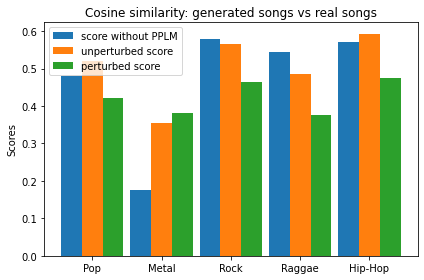

In [ ]:
labels = ['Pop', 'Metal', 'Rock', 'Raggae', 'Hip-Hop']
x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, non_pplm_list, width, label='score without PPLM')
rects2 = ax.bar(x, unperturbed_list, width, label='unperturbed score')
rects3 = ax.bar(x + width, perturbed_list, width, label='perturbed score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Cosine similarity: generated songs vs real songs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()